<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/A_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from IPython.display import display 

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive
Mounted at /content/gdrive


## prepare images

In [18]:
since = time.time()
data_source_dir = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
tar_file = os.path.join(data_source_dir, 'picked.tar')
if not os.path.exists('data'):
  os.mkdir('data')
! tar xf "{tar_file}" -C data/
print('%.3f' % (time.time() - since))

14.249
5.810
5.910


In [95]:
csv_file = os.path.join(data_source_dir, 'picked.csv')
df = pd.read_csv(csv_file, index_col=0)
df = df.loc[:, ['file', 'category_name', 'category_id']]
df['file'] = df.apply(lambda m: m.file[4:], axis=1)
df.head()

,file,category_name,category_id
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,Blouse,3
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,Blouse,3
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,Blouse,3
123023,New_York_City_Pocket_Tee/img_00000012.jpg,Tee,18
21889,Georgette_Tulip_Back_Blouse/img_00000029.jpg,Blouse,3


In [94]:
def pick(n_train, n_test, categories):
  df_pick = pd.DataFrame(columns=['file', 'label', 'type'])

  for cat in categories:
    indexes = df.loc[df.category_name == cat].index.values
    indexes = np.random.permutation(indexes)

    # trainset
    df_slice = df.loc[indexes[:n_train]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'train'

    df_pick = pd.concat([df_pick, df_slice])
    # testset
    df_slice = df.loc[indexes[n_train:n_train + n_test]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'test'
    df_pick = pd.concat([df_pick, df_slice])

  return df_pick

#############
df_pick = pick(2, 1, ['Tee', 'Blouse', 'Top'])
df_pick.head(10)


,file,label,type
85339,Eagles_Graphic_Muscle_Tee/img_00000007.jpg,Tee,train
94061,Floral_Lace-Paneled_Tee/img_00000005.jpg,Tee,train
56601,Venice_Cityscape_Muscle_Tee/img_00000008.jpg,Tee,test
15935,Ditsy_Floral_Print_Blouse/img_00000014.jpg,Blouse,train
212,Sheer_Woven_Blouse/img_00000064.jpg,Blouse,train
1265,Sleeveless_Classic_Woven_Blouse/img_00000127.jpg,Blouse,test
107977,Bead-Embellished_Top/img_00000018.jpg,Top,train
67682,Classic_Dolman_Top/img_00000015.jpg,Top,train
138561,Boxy_Lace_Ruffle_Top/img_00000023.jpg,Top,test


In [0]:
df_pick = pick(500, 200, ['Tee', 'Blouse', 'Top'])

## load data

Tee
(224, 224)


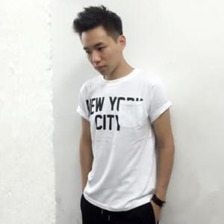

In [142]:
class ImageLabelDataset(Dataset):
  '''
  a dataset provides (image, label)
  '''
  def __init__(self, path:str, image_files, labels, transform=None, 
               normalization = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
    self.path = path
    self.image_files = image_files
    self.labels = labels
    self.transform = transform
    if normalization:
      self.normalizer = transforms.Normalize(normalization[0], normalization[1])

    assert(len(image_files) == len(labels))

  def __len__(self):
    return len(self.labels)
  
  def get(self, idx):
    file = os.path.join(self.path, self.image_files[idx])
    
    #image = io.imread(file)
    #image = Image.fromarray(image)
    image = Image.open(file)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return (image, label)

  def __getitem__(self, idx):
    image, label = self.get(idx)

    image = transforms.ToTensor()(image)

    if self.normalizer:
      image = self.normalizer(image)

    return (image, label)

##############################
image_ds = ImageLabelDataset('data/data/picked', ['New_York_City_Pocket_Tee/img_00000012.jpg'], ['Tee'], transform =  transforms.Resize(224))
assert(len(image_ds) == 1)

(image, label) = image_ds.get(0)
print(label)
assert(label == 'Tee')    

print(image.size)

display(image)

In [143]:
class DataSource():
  '''
  train_dl
  test_dl
  train_ds
  test_dl
  '''
  def __init__(self, path:str, df:pd.DataFrame, bs:int, transform=None, 
               num_workers=0):
      '''
      path : path of images
      df : DataFrame with file, label, type
      '''
      # convert labels to number
      labels = np.sort(df['label'].unique())
      self.class_names = np.sort(df['label'].unique())
      self.class_indexes = {c:i for i, c in enumerate(self.class_names)}
      self.c = len(self.class_names)
      self.labels = [self.class_indexes[c] for c in labels]


      is_train = df.type == 'train'
      self.train_ds = ImageLabelDataset(path, df[is_train]['file'].values, 
                                           [self.class_indexes[c] for c in df[is_train]['label'].values], 
                                           transform)
      self.test_ds = ImageLabelDataset(path, df[~is_train]['file'].values, 
                                          [self.class_indexes[c] for c in df[~is_train]['label'].values], 
                                           transform)

      self.train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True, 
                                 num_workers=num_workers)
      
      self.test_dl = DataLoader(self.test_ds, batch_size=bs, shuffle=False, 
                                 num_workers=num_workers)

############################################################################
df2 = df.head(3).copy()
df2.columns=['file', 'type', 'label']
df2['type'] = ['train', 'test', 'train']
df2['label'] = ['a', 'b', 'c']
print(df2.head())

ds = DataSource('data/data/picked', df2, 1)
assert(len(ds.train_ds) == 2)
assert(len(ds.test_ds) == 1)
assert(ds.c == 3)
assert(ds.test_ds[0][1] == 1)
assert(ds.class_names[ds.test_ds[0][1]] == 'b')

for (image, label) in ds.test_dl:
  print(type(image))
  print(image.shape)
  print(label)
  print(image[0, 0, 0, :20])
  break

                                                 file   type label
23063  Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg  train     a
30780     Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg   test     b
13998    Crochet_Lace-Paneled_Blouse/img_00000035.jpg  train     c
<class 'torch.Tensor'>
torch.Size([1, 3, 300, 207])
tensor([1])
tensor([2.1633, 2.1633, 2.1462, 2.1462, 2.1290, 2.1290, 2.1119, 2.1119, 2.1290,
        2.1290, 2.1290, 2.1119, 2.1119, 2.1119, 2.0948, 2.0948, 2.1119, 2.1119,
        2.1119, 2.1119])


In [0]:
df_pick = pick(200, 50, ['Tee', 'Blouse', 'Top'])

In [146]:
ds = DataSource('data/data/picked', df_pick, 2, transform = transforms.Compose([
  transforms.Resize(224)                                                                                
]))

images, labels = next(iter(ds.train_dl))
images.shape

RuntimeError: ignored

Tee
(224, 224)


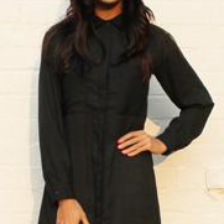

In [150]:
image_ds = ImageLabelDataset('data/data/picked', ['Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg'], ['Tee'], 
                             transform =  transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]))
assert(len(image_ds) == 1)

(image, label) = image_ds.get(0)
print(label)
assert(label == 'Tee')    

print(image.size)

display(image)